In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
# load text
filename = '/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv'
with open(filename, 'rt', encoding='ISO-8859-1') as file:
    text = file.read()

In [3]:
import string
from nltk.corpus import stopwords
import nltk

# Assuming NLTK stopwords are already downloaded
nltk.download('stopwords')

def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import csv
from collections import Counter

# Function to add words from a document to the vocabulary
def add_doc_to_vocab(text, vocab):
    words = text.split()
    vocab.update(words)

# Function to process CSV files
def process_csv(filename, vocab, is_train):
    with open(filename, 'r', encoding='ISO-8859-1') as file:
        reader = csv.reader(file)
        # Skip header if present
        next(reader, None)
        for row in reader:
            text = row[1]  # Assuming the text is in the second column, adjust as necessary
            if is_train and row[0] == 'cv9':
                continue
            if not is_train and row[0] != 'cv9':
                continue
            add_doc_to_vocab(text, vocab)

# Define vocab
vocab = Counter()
# Add all docs to vocab
process_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', vocab, is_train=True)
# Print the size of the vocab
print("Size of the vocabulary (Train):", len(vocab))
# Print the top words in the vocab
print("Top 50 words in the vocabulary (Train):", vocab.most_common(50))

Size of the vocabulary (Train): 41157
Top 50 words in the vocabulary (Train): [('48751', 1), ('48752', 1), ('48753', 1), ('48754', 1), ('48755', 1), ('48756', 1), ('48757', 1), ('48758', 1), ('48759', 1), ('48760', 1), ('48761', 1), ('48762', 1), ('48763', 1), ('48764', 1), ('48765', 1), ('48766', 1), ('48767', 1), ('48768', 1), ('48769', 1), ('48770', 1), ('48771', 1), ('48772', 1), ('48773', 1), ('48774', 1), ('48775', 1), ('48776', 1), ('48777', 1), ('48778', 1), ('48779', 1), ('48780', 1), ('48781', 1), ('48782', 1), ('48783', 1), ('48784', 1), ('48785', 1), ('48786', 1), ('48787', 1), ('48788', 1), ('48789', 1), ('48790', 1), ('48791', 1), ('48792', 1), ('48793', 1), ('48794', 1), ('48795', 1), ('48796', 1), ('48797', 1), ('48798', 1), ('48799', 1), ('48800', 1)]


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [13]:
# Function to process CSV files
def process_csv(filename, vocab, is_train):
    df = pd.read_csv(filename)
    documents = []
    for index, row in df.iterrows():
        text = row['OriginalTweet']  # Assuming the text is in a column named 'text', adjust as necessary
        if is_train and row['UserName'] == 'cv9':
            continue
        if not is_train and row['UserName'] != 'cv9':
            continue
        documents.append(text)
        add_doc_to_vocab(text, vocab)
    return documents

In [14]:
# Function to process CSV files
def process_csv(filename, vocab, is_train):
    df = pd.read_csv(filename)
    documents = []
    for index, row in df.iterrows():
        text = row['OriginalTweet']  # Assuming the text is in a column named 'text', adjust as necessary
        if is_train and row['UserName'] == 'cv9':
            continue
        if not is_train and row['UserName'] != 'cv9':
            continue
        documents.append(text)
        add_doc_to_vocab(text, vocab)
    return documents

In [12]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')

# Assuming you have a column named 'Tweets' for the text data and a column named 'Labels' for the target labels
X = data['OriginalTweet']
y = data['UserName']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences for X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
max_length = 100  # Define the maximum length of sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')

# Define vocab_size and max_length
vocab_size = len(tokenizer.word_index) + 1

# Tokenize and pad sequences for X_test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [15]:
# Print vocab size
print("Vocabulary size:", vocab_size)

Vocabulary size: 72502


In [16]:
# Print max length
print("Maximum sequence length:", max_length)

Maximum sequence length: 100


In [20]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define preprocess_text function
def preprocess_text(text):
    # Convert text to lowercase if it's a string
    if isinstance(text, str):
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Read the CSV file
df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')

# Apply preprocess_text function to each element of 'text' column
X_train = df['OriginalTweet'].apply(preprocess_text)
y_train = df['UserName']  # Assuming 'textID' is the column name for the target labels

vocab_size = 10000  
max_length = 100  

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'data' is the DataFrame loaded from the CSV
le = LabelEncoder()
df['target'] = le.fit_transform(df['OriginalTweet'])

# Convert Tweets column to strings
df['OriginalTweet'] = df['OriginalTweet'].astype(str)

# Convert Tweets to sequences and pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['OriginalTweet'])
sequences = tokenizer.texts_to_sequences(df['OriginalTweet'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=8))  # Removed input_length parameter
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(padded_sequences, df['target'], epochs=10, batch_size=32, validation_split=0.2)

# Summarize the model
print(model.summary())

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0000e+00 - loss: -131482352.0000 - val_accuracy: 1.2148e-04 - val_loss: -1233734912.0000
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: -1925564928.0000 - val_accuracy: 1.2148e-04 - val_loss: -4539446272.0000
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0000e+00 - loss: -5647485440.0000 - val_accuracy: 1.2148e-04 - val_loss: -9403834368.0000
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0000e+00 - loss: -10843530240.0000 - val_accuracy: 1.2148e-04 - val_loss: -15578166272.0000
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: -17184110592.0000 - val_accuracy: 1.2148e-04 - val_loss: -22959306752.0000
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: -25048369152.0000 - val_accuracy: 1.2148e-04 - val_loss: -31462475776.0000
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 2s 2m

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,405 (946.90 KB)

 Trainable params: 80,801 (315.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,604 (631.27 KB)

None


In [22]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target labels
y_test_encoded = label_encoder.fit_transform(y_test)

# Convert y_test_encoded to a 2D array
y_test_encoded = y_test_encoded.reshape(-1, 1)

# Now, evaluate the model with encoded labels
loss, acc = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print('Test Accuracy: %.2f%%' % (acc * 100))

Test Accuracy: 0.01%


In [26]:
# OriginalTweet Column

import pandas as pd
from textblob import TextBlob

# Read the CSV file
data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')

# Handle NaN values if necessary
data.dropna(subset=['OriginalTweet'], inplace=True)

# Calculating sentiment polarity for each review
data['Sentiment'] = data['OriginalTweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Displaying the DataFrame with the sentiment column
print(data)

       UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet  Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i

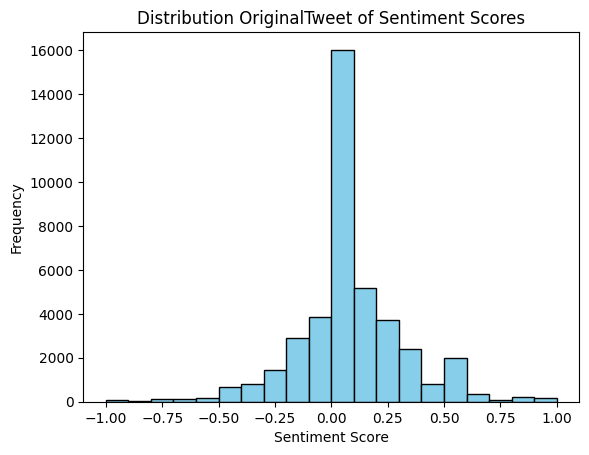

In [25]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')

# Define a function to calculate sentiment polarity
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the text columns
data['Sentiment_Score'] = data['OriginalTweet'].apply(calculate_sentiment)

# Visualize the sentiment scores
plt.hist(data['Sentiment_Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution OriginalTweet of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Sentiment score 0.0 - 0.10 is the most reached 16000 frequency that showed in bar graph

In [28]:
# Label Column

import pandas as pd
from textblob import TextBlob

# Read the CSV file
data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')

# Handle NaN values if necessary
data.dropna(subset=['Sentiment'], inplace=True)

# Calculating sentiment polarity for each review
data['Sentiment'] = data['Sentiment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Displaying the DataFrame with the sentiment column
print(data)

       UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet  Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i

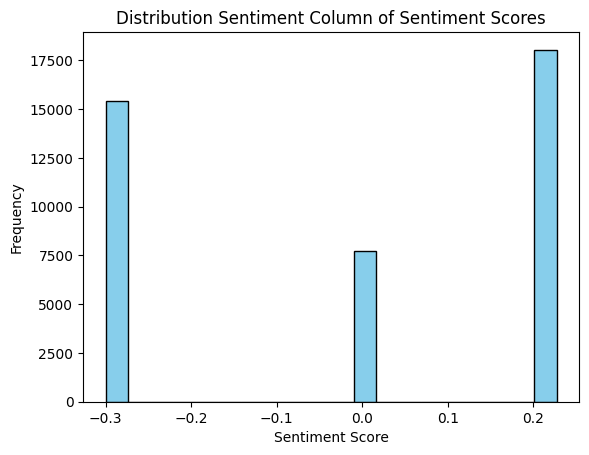

In [30]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')

# Define a function to calculate sentiment polarity
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the text columns
data['Sentiment_Score'] = data['Sentiment'].apply(calculate_sentiment)

# Visualize the sentiment scores
plt.hist(data['Sentiment_Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution Sentiment Column of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Sentiment Analysis Score in sentiment columns showed that 0.2 is the most frequency 17500